### Zadanie 13 (10p)

Pobierz plik `Credit.csv` opisany tutaj. Twoim zadaniem jest znalezienie modelu, który będzie miał możliwie dużą skuteczność przewidywania:
- **(a)** czy dana osoba ma dochód większy niż $50$ (wskazówka: stwórz nową zmienną indykatorową na bazie `Income` i usuń zmienną `Income`),

- **(b)** ile kart kredytowych posiada dana osoba.


Rozważ różne modele, np. *regresje logistyczną*, *drzewa decyzyjne*, *lasy losowe*, *k-najbliższych sąsiadów*, oraz różne parametry modeli (np. maksymalna głębokość drzewa, różne wartości $k$ najbliższych sąsiadów). Możesz wykorzystać implementację tych modeli np. z pakietu
`scikit-learn`.
Jaką dokładność (*ang. accuracy*) ma najlepszy model, który udało Ci się uzyskać w przypadku **(a)** i **(b)**? Aby uzyskać wiarygodną odpowiedź użyj *walidacji krzyżowej* do przeprowadzenia wielu eksperymentów w oparciu o jeden zbiór danych. Np. użyj metody *KFold*. Narysuj wykresy typu box-plot, aby wygodnie porównywać modele, uwzględniając nie tylko
średnią dokładność ale również wariancję wyników. Możesz zobaczyć przykłady w tym Jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from patsy import dmatrices, dmatrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
cards_df = pd.read_csv('Credit.csv')
# Set parameters as categorical
cards_df['Gender'] = cards_df['Gender'].astype('category')
cards_df['Student'] = cards_df['Student'].astype('category')
cards_df['Married'] = cards_df['Married'].astype('category')
cards_df['Ethnicity'] = cards_df['Ethnicity'].astype('category')

print(cards_df.shape)
# Display the first few rows of the dataframe
cards_df.head()

(400, 12)


,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
income_df = pd.read_csv('Credit.csv')

# Create a new indicator variable based on Income
income_df['HighIncome'] = (income_df['Income'] > 50).astype(int)

# Drop the original Income column
income_df.drop(columns=['Income'], inplace=True)

# Set parameters as categorical
income_df['Gender']     = income_df['Gender'].astype('category')
income_df['Student']    = income_df['Student'].astype('category')
income_df['Married']    = income_df['Married'].astype('category')
income_df['Ethnicity']  = income_df['Ethnicity'].astype('category')
income_df['HighIncome'] = income_df['HighIncome'].astype('category')

print(income_df.shape)

income_df.head()

(400, 12)


,Unnamed: 0,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,HighIncome
0,1,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,2,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,3,7075,514,4,71,11,Male,No,No,Asian,580,1
3,4,9504,681,3,36,11,Female,No,No,Asian,964,1
4,5,4897,357,2,68,16,Male,No,Yes,Caucasian,331,1


In [4]:
income_df.dtypes

Unnamed: 0       int64
Limit            int64
Rating           int64
Cards            int64
Age              int64
Education        int64
Gender        category
Student       category
Married       category
Ethnicity     category
Balance          int64
HighIncome    category
dtype: object

In [5]:
assert (len(income_df)) == (len(cards_df))

income_train_df, income_test_df = train_test_split(income_df, test_size=0.2, random_state=42)
cards_train_df, cards_test_df = train_test_split(cards_df, test_size=0.2, random_state=42)

# mask = np.random.rand(len(income_df)) < 0.8

# income_train_df = income_df[mask]
# income_test_df = income_df[~mask]

# cards_train_df = cards_df[mask]
# cards_test_df = cards_df[~mask]

print(income_train_df.shape)
print(income_test_df.shape)

print(cards_train_df.shape)
print(cards_test_df.shape)

(320, 12)
(80, 12)
(320, 12)
(80, 12)


In [6]:
income_train_df.head()

,Unnamed: 0,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,HighIncome
3,4,9504,681,3,36,11,Female,No,No,Asian,964,1
18,19,6384,448,1,28,9,Female,No,Yes,Asian,891,0
202,203,1448,145,2,58,13,Female,No,Yes,Caucasian,0,0
250,251,2430,191,2,47,18,Female,No,Yes,Asian,0,0
274,275,5869,439,5,81,9,Female,No,No,African American,967,0


In [7]:
cards_train_df.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
18,19,49.570,6384,448,1,28,9,Female,No,Yes,Asian,891
202,203,21.038,1448,145,2,58,13,Female,No,Yes,Caucasian,0
250,251,10.363,2430,191,2,47,18,Female,No,Yes,Asian,0
274,275,30.550,5869,439,5,81,9,Female,No,No,African American,967


In [12]:
models = []
models.append(('LRE ', LogisticRegression(max_iter=100000)))
# models.append(('DTCGin', DecisionTreeClassifier(criterion='gini')))
models.append(('DTCEnt', DecisionTreeClassifier(criterion='entropy')))
models.append(('DTCLL', DecisionTreeClassifier(criterion='log_loss')))
models.append(('DTC3', DecisionTreeClassifier(max_depth=3)))
models.append(('DTC10', DecisionTreeClassifier(max_depth=10)))
models.append(('RFC3', RandomForestClassifier(max_depth=3)))
models.append(('RFC10', RandomForestClassifier(max_depth=10)))
models.append(('RFCn1', RandomForestClassifier(n_estimators=1)))
models.append(('RFCn4', RandomForestClassifier(n_estimators=4)))
# models.append(('RFC', RandomForestClassifier()))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5)))

# models.append(('LRE ', LogisticRegression(max_iter=100000)))
# models.append(('DTCGin', DecisionTreeClassifier(criterion='gini')))
# models.append(('RFC3', RandomForestClassifier(max_depth=3)))
# models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))



In [13]:
X = income_df.drop(columns=['HighIncome'])
y = income_df['HighIncome']

X = pd.get_dummies(X, drop_first=True)

print(X.dtypes)
print(X)
print(y)

Unnamed: 0             int64
Limit                  int64
Rating                 int64
Cards                  int64
Age                    int64
Education              int64
Balance                int64
Gender_Female           bool
Student_Yes             bool
Married_Yes             bool
Ethnicity_Asian         bool
Ethnicity_Caucasian     bool
dtype: object
     Unnamed: 0  Limit  Rating  Cards  Age  Education  Balance  Gender_Female  \
0             1   3606     283      2   34         11      333          False   
1             2   6645     483      3   82         15      903           True   
2             3   7075     514      4   71         11      580          False   
3             4   9504     681      3   36         11      964           True   
4             5   4897     357      2   68         16      331          False   
..          ...    ...     ...    ...  ...        ...      ...            ...   
395         396   4100     307      3   32         13      560         

LRE :		mean: 0.950000		std: 0.025000
DTCEnt:		mean: 0.912500		std: 0.037500
DTCLL:		mean: 0.912500		std: 0.037500
DTC3:		mean: 0.900000		std: 0.048734
DTC10:		mean: 0.902500		std: 0.030516
RFC3:		mean: 0.842500		std: 0.037165
RFC10:		mean: 0.895000		std: 0.031225
RFCn1:		mean: 0.830000		std: 0.061033
RFCn4:		mean: 0.865000		std: 0.032016
KNN1:		mean: 0.920000		std: 0.026926
KNN5:		mean: 0.932500		std: 0.040389


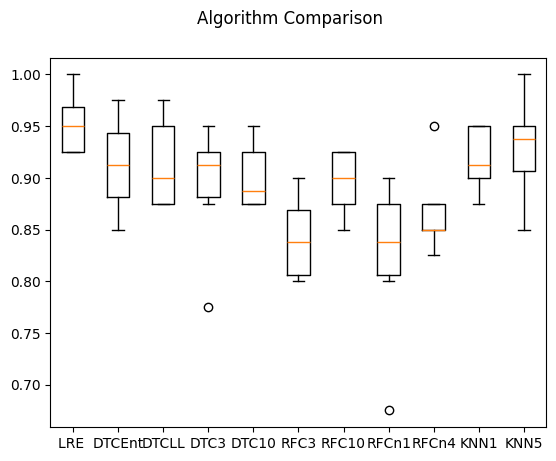

In [14]:
# set seed for cross validation
seed = 1

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t\tmean: %f\t\tstd: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LRE :		mean: 0.220000		std: 0.048477
DTCEnt:		mean: 0.215000		std: 0.069101
DTCLL:		mean: 0.245000		std: 0.074833
DTC3:		mean: 0.265000		std: 0.073485
DTC10:		mean: 0.230000		std: 0.078102
RFC3:		mean: 0.245000		std: 0.045826
RFC10:		mean: 0.275000		std: 0.064226
RFCn1:		mean: 0.230000		std: 0.049749
RFCn4:		mean: 0.237500		std: 0.084595
KNN1:		mean: 0.242500		std: 0.048798
KNN5:		mean: 0.195000		std: 0.053385


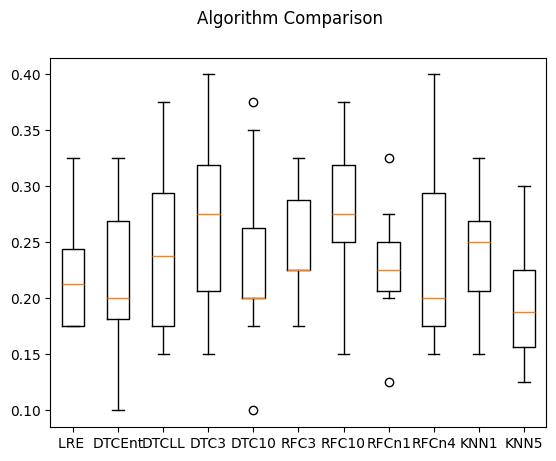

In [15]:
from sklearn.preprocessing import StandardScaler

X = cards_df.drop(columns=['Cards'])
y = cards_df['Cards']

X = pd.get_dummies(X, drop_first=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t\tmean: %f\t\tstd: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()